2022-11-29 16:52:19,695 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|1000/1000, best_cost=0.28
2022-11-29 16:54:22,080 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.2800000000000001, best pos: [1 1 1 1 1 1 1 0 1 0 1 1 1 1 1]


Subset performance: 0.700


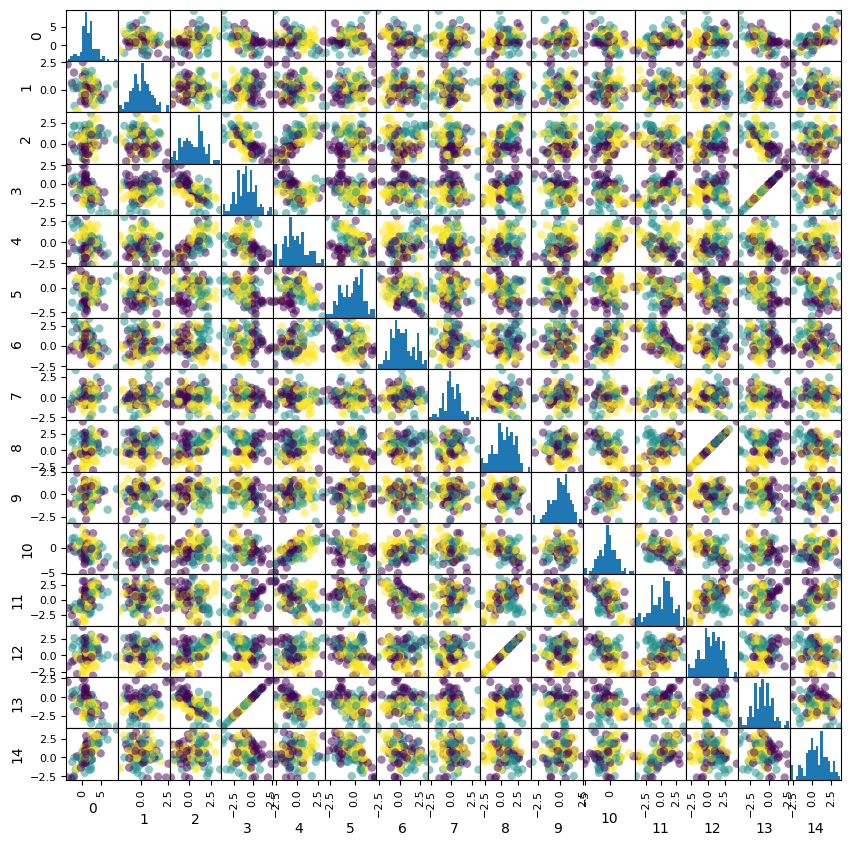

In [3]:
# Import modules
import numpy as np
import random
# Import PySwarms
import pyswarms as ps
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
import pandas as pd

from sklearn.datasets import make_classification
from sklearn import linear_model

X, y = make_classification(n_samples=100, n_features=15, n_classes=3,
n_informative=5, n_redundant=5, n_repeated=2,
random_state=1)


data_dataframe = pd.DataFrame(X)
grr = pd.plotting.scatter_matrix(data_dataframe,c=y,figsize=(10,10),marker='o',hist_kwds={'bins':20},alpha=0.5)


classifier = linear_model.LogisticRegression()

def f_per_particle(m, alpha):
    """Computes for the objective function per particle
    Inputs
    ------
    m : numpy.ndarray
    Binary mask that can be obtained from BinaryPSO, will
    be used to mask features.
    alpha: float (default is 0.5)
    Constant weight for trading-off classifier performance
    and number of features
    Returns
    -------
    numpy.ndarray
    Computed objective function
    """
    total_features = 15
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0:
        X_subset = X
    else:
        X_subset = X[:,m==1]
    # Perform classification and store performance in P
    classifier.fit(X_subset, y)
    P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.
    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
    The swarm that will perform the search
    Returns
    -------
    numpy.ndarray of shape (n_particles, )
    The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

# Initialize swarm, arbitrary
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 30, 'p':2}
# Call instance of PSO
dimensions = 15 # dimensions should be the number of features
optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions,
options=options)
cost, pos = optimizer.optimize(f, iters=1000)

# Create two instances of LogisticRegression
classifier = linear_model.LogisticRegression()
# Get the selected features from the final positions
X_selected_features = X[:,pos==1] # subset
# Perform classification and store performance in P
classifier.fit(X_selected_features, y)
# Compute performance
subset_performance = (classifier.predict(X_selected_features) == y).mean()
print('Subset performance: %.3f' % (subset_performance))